# Hierarchical LDA Demo

This notebook demonstrates how we can load the BBC Insight Dataset (http://mlg.ucd.ie/datasets/bbc.html), preprocess them via NLTK and run hierarchical LDA inference on the data. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys

basedir = "../"
sys.path.append(basedir)

import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from hlda.sampler import HierarchicalLDA
from ipywidgets import widgets
from IPython.core.display import HTML, display

import string
import glob

## 1. Load test corpus

Load and preprocess text using NLTK. Below we load all tech articles from the BBC Insight corpus.

In [2]:
stopset = (
    stopwords.words("english") + list(string.punctuation) + ["will", "also", "said"]
)

In [3]:
corpus = []
all_docs = []
vocab = set()

# Save a representative full token for each lemma (for friendly display).
# Each key -> 2nd level Dictionary of counts for full forms
stem_to_word_count = {}

stemmer = PorterStemmer()

In [4]:
for filename in glob.glob("../bbc/tech/*.txt"):
    with open(filename) as f:
        doc = f.read().splitlines()
        doc = [line for line in doc if line]  # remove empty lines
        doc = " ".join(doc)
        char_stripper = str.maketrans(
            "", "", string.punctuation + "0123456789"
        )  # strip punctuation and numbers
        doc = doc.translate(char_stripper)
        doc = doc.encode("ascii", "ignore").decode()  # ignore fancy unicode chars
        all_docs.append(doc)

        tokens = word_tokenize(str(doc))
        filtered = []
        for w in tokens:
            if w in stopset:  # remove stop words
                continue
            if len(w) < 3:  # remove short tokens
                continue

            stem = stemmer.stem(w.lower())  # use Porter's stemmer
            # Save friendly version
            if stem not in stem_to_word_count:
                stem_to_word_count[stem] = {}
            if w not in stem_to_word_count[stem]:
                stem_to_word_count[stem][w] = 1
            else:
                stem_to_word_count[stem][w] += 1

            filtered.append(stem)

        vocab.update(filtered)
        corpus.append(filtered)

In [5]:
# Flatten stem_to_word to the full word with the highest count
stem_to_word = {}

for stem, counts in stem_to_word_count.items():
    highest = ["", 0]
    for word, count in counts.items():
        if count > highest[1]:
            highest = [word, count]

    stem_to_word[stem] = highest[0]

Create an inverted index for the words to position in the sorted vocab

In [6]:
vocab = sorted(list(vocab))
vocab_index = {}
for i, w in enumerate(vocab):
    vocab_index[w] = i

Total number of documents in the corpus

In [7]:
print(len(all_docs))

401


Total number of vocab. Also print the first 500 words in the sorted vocab.

In [8]:
print(len(vocab))
print(vocab[0:100])

8296
['aaa', 'aac', 'aadc', 'aarhu', 'aaron', 'abacu', 'abandon', 'abat', 'abbott', 'abensur', 'abet', 'abid', 'abil', 'abl', 'ablebodi', 'about', 'aboutroughli', 'aboveaverag', 'abraham', 'abramovich', 'abroad', 'abruptli', 'absenc', 'absolut', 'absorb', 'abstain', 'abstract', 'abtahi', 'abund', 'abundantli', 'abus', 'academ', 'academi', 'academia', 'acceler', 'accept', 'access', 'accessori', 'accid', 'accident', 'acclaim', 'acclim', 'accolad', 'accommod', 'accompani', 'accomplic', 'accomplish', 'accord', 'accordingli', 'account', 'accumul', 'accur', 'accuraci', 'accus', 'achiev', 'acid', 'acknowledg', 'acquiesc', 'acquir', 'acquisit', 'acquit', 'acr', 'acrobat', 'across', 'act', 'action', 'actionfest', 'actionpack', 'activ', 'activcard', 'actor', 'actual', 'acut', 'ad', 'adam', 'adamind', 'adapt', 'adaptor', 'adawar', 'add', 'addict', 'addin', 'addit', 'addon', 'address', 'adept', 'adequ', 'adher', 'adict', 'adida', 'adjudg', 'adjust', 'administ', 'administr', 'admit', 'admittedli', 

## 2. Visualise the data

Make some pretty word cloud using the Python Word Cloud package: https://github.com/amueller/word_cloud

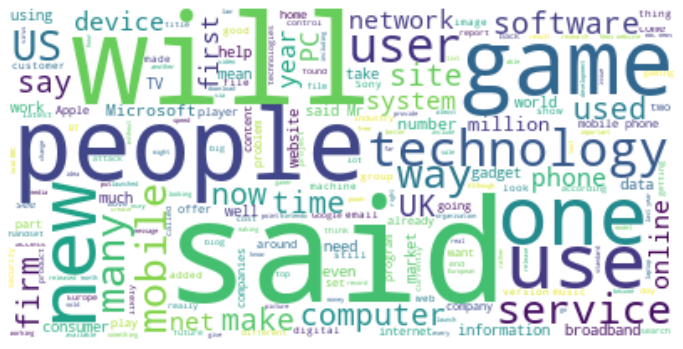

In [9]:
wordcloud = WordCloud(background_color="white").generate(" ".join(all_docs))
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 3. Run hLDA

In [10]:
print(len(vocab), len(corpus), len(corpus[0]), len(corpus[1]))

8296 401 386 215


Convert words in the corpus into indices

In [11]:
new_corpus = []
for doc in corpus:
    new_doc = []
    for word in doc:
        word_idx = vocab_index[word]
        new_doc.append(word_idx)
    new_corpus.append(new_doc)

In [12]:
print(len(vocab), len(new_corpus))
print(corpus[0][0:10])
print(new_corpus[0][0:10])

8296 401
['ink', 'help', 'drive', 'democraci', 'asia', 'the', 'kyrgyz', 'republ', 'small', 'mountain']
[3635, 3252, 2053, 1809, 408, 7330, 3980, 6046, 6670, 4666]


Create hierarchical LDA object and run the sampler.

In [13]:
n_samples = 500  # no of iterations for the sampler
alpha = 10.0  # smoothing over level distributions
gamma = 1.0  # CRP smoothing parameter; number of imaginary customers at next, as yet unused table
eta = 0.1  # smoothing over topic-word distributions
num_levels = 3  # the number of levels in the tree
display_topics = (
    50  # the number of iterations between printing a brief summary of the topics so far
)
n_words = 5  # the number of most probable words to print for each topic after model estimation
with_weights = False  # whether to print the words with the weights

In [14]:
hlda = HierarchicalLDA(
    new_corpus, vocab, alpha=alpha, gamma=gamma, eta=eta, num_levels=num_levels
)
hlda.estimate(
    n_samples, display_topics=display_topics, n_words=n_words, with_weights=with_weights
)

HierarchicalLDA sampling

.................................................. 50
topic=0 level=0 (documents=401): the, use, peopl, could, get
    topic=1 level=1 (documents=310): mobil, phone, the, music, digit
        topic=2 level=2 (documents=174): game, search, softwar, the, develop
        topic=3 level=2 (documents=88): site, secur, user, net, program
        topic=10 level=2 (documents=13): robot, game, develop, nintendo, argonaut
        topic=14 level=2 (documents=9): dvd, technolog, bluray, game, format
        topic=18 level=2 (documents=16): email, viru, domain, the, messag
        topic=20 level=2 (documents=10): laser, light, ink, use, silicon
    topic=4 level=1 (documents=10): game, learn, charact, player, sim
        topic=5 level=2 (documents=10): game, play, hour, time, addict
    topic=6 level=1 (documents=38): phone, mobil, broadband, peopl, year
        topic=7 level=2 (documents=13): printer, imag, cartridg, month, lab
        topic=9 level=2 (documents=7): simone

.................................................. 300
topic=0 level=0 (documents=401): the, use, peopl, could, get
    topic=1 level=1 (documents=288): mobil, phone, technolog, the, music
        topic=2 level=2 (documents=127): game, the, softwar, soni, releas
        topic=3 level=2 (documents=76): site, secur, email, program, net
        topic=10 level=2 (documents=17): robot, game, dvd, highdefinit, screen
        topic=14 level=2 (documents=15): technolog, dvd, mobil, bluray, game
        topic=18 level=2 (documents=16): email, domain, viru, appl, messag
        topic=20 level=2 (documents=17): laser, light, power, silicon, intel
        topic=27 level=2 (documents=5): ink, elect, lab, govern, panda
        topic=28 level=2 (documents=9): net, china, regul, tremor, chines
        topic=29 level=2 (documents=6): musician, lift, librari, book, record
    topic=4 level=1 (documents=15): player, phone, mobil, music, learn
        topic=5 level=2 (documents=15): game, play, hour, time

## 4. Visualise results

In [20]:
colour_map = {0: "blue", 1: "red", 2: "green"}


def show_doc(d=0):

    node = hlda.document_leaves[d]
    path = []
    while node is not None:
        path.append(node)
        node = node.parent
    path.reverse()

    n_words = 10
    with_weights = False
    for n in range(len(path)):
        node = path[n]
        colour = colour_map[n]
        msg = "Level %d Topic %d: " % (node.level, node.node_id)
        top_words = node.get_top_words(n_words, with_weights)
        msg += ", ".join([stem_to_word[stem] for stem in top_words])
        output = '<h%d><span style="color:%s">%s</span></h3>' % (n + 1, colour, msg)
        display(HTML(output))

    display(HTML("<hr/><h5>Processed Document</h5>"))

    doc = corpus[d]
    output = ""
    for n in range(len(doc)):
        w = doc[n]
        # Friendly display
        w = stem_to_word[w]
        l = hlda.levels[d][n]
        colour = colour_map[l]
        output += '<span style="color:%s">%s</span> ' % (colour, w)
    display(HTML(output))

If you run this notebook locally, you'd be able to flip through the documents in the corpus and see the topic assignments of individual words of the document.

In [21]:
widgets.interact(show_doc, d=(0, len(corpus) - 1))

interactive(children=(IntSlider(value=0, description='d', max=400), Output()), _dom_classes=('widget-interact'…

<function __main__.show_doc(d=0)>

## 5. Dump the hlda object for further use later

https://stackoverflow.com/questions/18474791/decreasing-the-size-of-cpickle-objects

In [17]:
import pickle
import gzip


def save_zipped_pickle(obj, filename, protocol=-1):
    with gzip.open(filename, "wb") as f:
        pickle.dump(obj, f, protocol)


def load_zipped_pickle(filename):
    with gzip.open(filename, "rb") as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [18]:
save_zipped_pickle(hlda, "bbc_hlda.p")

In [19]:
hlda = load_zipped_pickle("bbc_hlda.p")